In [219]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline

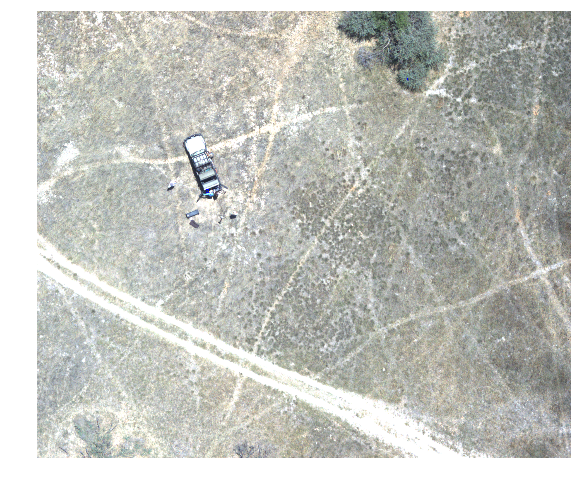

In [220]:
# based on the OpenCV tutorial
# https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_core/py_basic_ops/py_basic_ops.html#basic-ops

raw = cv2.imread('test.png')
image = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)

my_dpi = 160
plt.figure(figsize=(1900/my_dpi, 1280/my_dpi), dpi=my_dpi)
plt.axis('off')
plt.imshow(image)

In [221]:
###########################
### Spectral Analysis
###########################

HISTOGRAM_COUNT_THRESHOLD = 500
HISTOGRAM_BITS_PER_COLOR = 3
NUM_BINS = 1 << HISTOGRAM_BITS_PER_COLOR

class BinStats:
    spacing = 0
    min = 0
    max = 0
    
class Bin:
    r = BinStats()
    g = BinStats()
    b = BinStats()
    
def InitBin(image):
    bin = Bin()
    
    r = image[:,:,0]
    bin.r.min = np.min(r)
    bin.r.max = np.max(r)
    bin.r.spacing = 1 + (bin.r.max - bin.r.min)/NUM_BINS
    print "min_r=%i, max_r=%i, bin_spacing.r=%i" % (bin.r.min, bin.r.max, bin.r.spacing)
    
    g = image[:,:,1]
    bin.g.min = np.min(g)
    bin.g.max = np.max(g)
    bin.g.spacing = 1 + (bin.g.max - bin.g.min)/NUM_BINS
    print "min_g=%i, max_g=%i, bin_spacing.g=%i" % (bin.g.min, bin.g.max, bin.g.spacing)
    
    b = image[:,:,2]
    bin.b.min = np.min(b)
    bin.b.max = np.max(b)
    bin.b.spacing = 1 + (bin.b.max - bin.b.min)/NUM_BINS
    print "min_b=%i, max_b=%i, bin_spacing.b=%i" % (bin.b.min, bin.b.max, bin.b.spacing)
    
    return bin
    
def InitLUT(bin):
    r_lut = np.zeros(256)
    g_lut = np.zeros(256)
    b_lut = np.zeros(256)
    
    for i in range(256):
        r_lut[i] = (i - bin.r.min) / bin.r.spacing
        if r_lut[i] >= NUM_BINS:
            r_lut[i] = NUM_BINS - 1
            
        g_lut[i] = (i - bin.g.min) / bin.g.spacing
        if g_lut[i] >= NUM_BINS:
            g_lut[i] = NUM_BINS - 1
            
        b_lut[i] = (i - bin.b.min) / bin.b.spacing
        if b_lut[i] >= NUM_BINS:
            b_lut[i] = NUM_BINS - 1
    
#    print r_lut
#    print g_lut
#    print b_lut
    
    return r_lut,g_lut,b_lut

def quantize(image, lut):
    height,width,depth = image.shape
    print "image height=%i,width=%i,depth=%i" % (height,width,depth)
    
    r_lut,g_lut,b_lut = lut
    
    r = image[:,:,0]
    g = image[:,:,1]
    b = image[:,:,2]
    
    qimage = np.zeros((height,width,depth),dtype='uint8')
    qimage_r = qimage[:,:,0]
    qimage_g = qimage[:,:,1]
    qimage_b = qimage[:,:,2]
    
    for h in range(height):
        for w in range(width):
            qimage_r[h][w] = r_lut[r[h][w]]
            qimage_g[h][w] = g_lut[g[h][w]]
            qimage_b[h][w] = b_lut[b[h][w]]
            
    return qimage

def is_zero_pixel(pixel):
    r,g,b = pixel
    
    return r == 0 and g == 0 and b == 0

def unquantize(qimage, bin):
    height,width,depth = qimage.shape
    print "qimage height=%i,width=%i,depth=%i" % (height,width,depth)
    
    qimage_r = qimage[:,:,0]
    qimage_g = qimage[:,:,1]
    qimage_b = qimage[:,:,2]
    
    dimage = np.zeros((height,width,depth),dtype='uint8')
    dimage_r = dimage[:,:,0]
    dimage_g = dimage[:,:,1]
    dimage_b = dimage[:,:,2]
    
    for h in range(height):
        for w in range(width):
            if is_zero_pixel(qimage[h][w]):
                dimage[h][w] = qimage[h][w]
            else:
                dimage_r[h][w] = qimage_r[h][w] * bin.r.spacing + bin.r.min
                dimage_g[h][w] = qimage_g[h][w] * bin.g.spacing + bin.g.min
                dimage_b[h][w] = qimage_b[h][w] * bin.b.spacing + bin.b.min
    
    return dimage

def BuildPixel(rgb):
    r,g,b = rgb
    
    return (r << 2*HISTOGRAM_BITS_PER_COLOR) + (g << HISTOGRAM_BITS_PER_COLOR) + b
    
def BuildHistogram(qimage):
    height,width,depth = qimage.shape
    hist = np.zeros(512)
    
    for h in range(height):
        for w in range(width):
            rgb = qimage[h,w]
            pixel = BuildPixel(rgb)
            hist[pixel] += 1
            hist[pixel] = min(hist[pixel], 10000)
    
    return hist

def HistogramThreshold(qimage, hist):
    height,width,depth = qimage.shape
    
    mask = np.zeros((height,width,depth),dtype='uint8')
    mask_r = mask[:,:,0]
    mask_g = mask[:,:,1]
    mask_b = mask[:,:,2]
    
    for h in range(height):
        for w in range(width):
            pixel = BuildPixel(qimage[h,w])
            if hist[pixel] > HISTOGRAM_COUNT_THRESHOLD:
                mask_r[h,w] = mask_g[h,w] = mask_b[h,w] = 0
            else:
                mask[h,w] = qimage[h,w]
    
    return mask
    
def hist(image):
    divisor = 32
    nbins = 256/divisor

    r_bin = np.zeros(nbins)
    g_bin = np.zeros(nbins)
    b_bin = np.zeros(nbins)

    b,g,r = image[:,:,0],image[:,:,1],image[:,:,2]

    for i in range(b.shape[0]):
        for j in range(b.shape[1]):
            val = r[i,j]/divisor
            r_bin[val] += 1

            val = g[i,j]/divisor
            g_bin[val] += 1

            val = b[i,j]/divisor
            b_bin[val] += 1
    
    return r_bin,g_bin,b_bin

def plot(bins):
    x_axis = range(8)
    r_bin,g_bin,b_bin = bins
    r_bin[-1] = g_bin[-1] = b_bin[-1] = 0
    
    plt.plot(x_axis, r_bin, color='red')
    plt.plot(x_axis, g_bin, color='green')
    plt.plot(x_axis, b_bin, color='blue')

min_r=0, max_r=255, bin_spacing.r=32
min_g=0, max_g=255, bin_spacing.g=32
min_b=34, max_b=255, bin_spacing.b=28
image height=2048,width=2448,depth=3
qimage height=2048,width=2448,depth=3


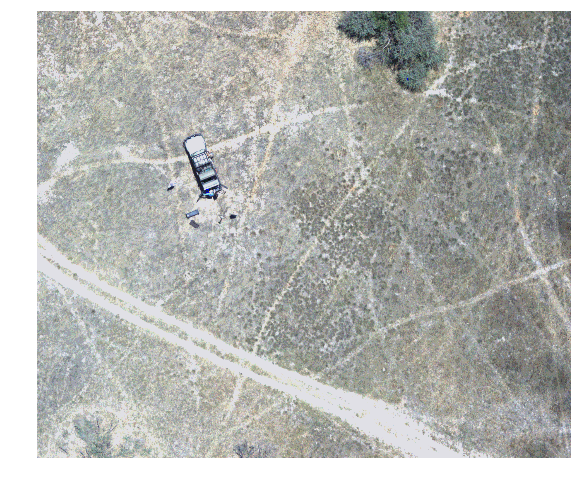

In [222]:
bin = InitBin(image)
lut = InitLUT(bin)
qimage = quantize(image, lut)
dimage = unquantize(qimage, bin)

my_dpi = 160
plt.figure(figsize=(1900/my_dpi, 1280/my_dpi), dpi=my_dpi)
plt.axis('off')
plt.imshow(dimage)

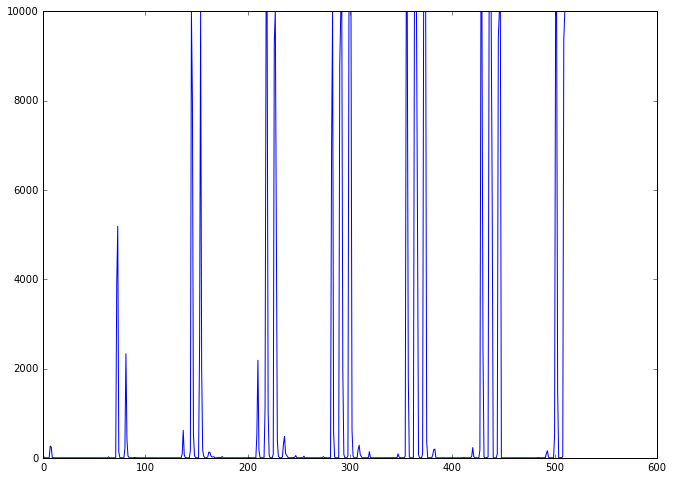

In [223]:
hist = BuildHistogram(qimage)
hist_index = range(512)

my_dpi = 160
plt.figure(figsize=(1900/my_dpi, 1280/my_dpi), dpi=my_dpi)
plt.plot(hist_index, hist)

qimage height=2048,width=2448,depth=3


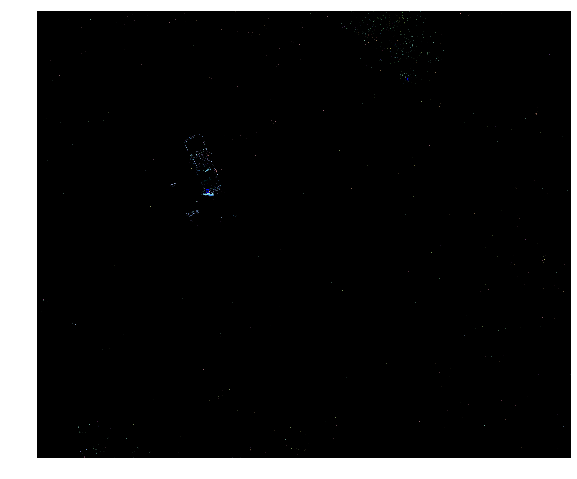

In [224]:
mask = HistogramThreshold(qimage, hist)
dimage = unquantize(mask, bin)

my_dpi = 160
plt.figure(figsize=(1900/my_dpi, 1280/my_dpi), dpi=my_dpi)
plt.axis('off')
plt.imshow(dimage)

In [273]:
########################
### Spatial Analysis
########################

MAX_REGIONS = 4000
REGION_UNKNOWN = -2
REGION_NONE = -1

MAX_REGION_AREA = 0.25
MIN_REGION_AREA = 0.04
MAX_REGION_SIZE = 0.5
MIN_REGION_SIZE = 0.2

MIN_REGION_SCORE = 600

class ARegion:
    def __init__(self):
        self.minx = 0
        self.maxx = 0
        self.miny = 0
        self.maxy = 0
        self.score = 0
        self.size = 0
    
class Regions:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.num_regions = 0
        self.catalog = []
        
        self.data = np.zeros((self.height,self.width),dtype='int')
        for h in range(self.height):
            for w in range(self.width):
                self.data[h,w] = REGION_UNKNOWN

def FindRegion(regions, w, h):
    region_merge = regions.width / 100
    
    for yofs in range(-1*region_merge, 1):
        for xofs in range(-1*region_merge, region_merge+1):
            if yofs+h < 0:
                continue
            if xofs+w < 0:
                continue
            if xofs+w >= regions.width:
                continue
            
            if regions.data[yofs+h][xofs+w] >= 0:
                return regions.data[yofs+h][xofs+w]
            
    for xofs in range(-1*region_merge, 0):
        if xofs+w  < 0:
            continue
        if regions.data[h][xofs+w] >= 0:
            return regions.data[h][xofs+w]
        
    return REGION_NONE
    
def AssignRegions(mask):
    height,width,depth = mask.shape
    
    regions = Regions(width, height)
    for h in range(height):
        for w in range(width):
            if regions.data[h,w] == REGION_UNKNOWN:
                if is_zero_pixel(mask[h,w]):
                    regions.data[h,w] = REGION_NONE
                    continue
                
                if regions.num_regions == MAX_REGIONS:
                    return regions
                    
                r = FindRegion(regions, w, h)
                if r == REGION_NONE:
                    r = regions.num_regions
                    regions.num_regions += 1
                    
                    aregion = ARegion()
                    aregion.minx = w
                    aregion.maxx = w
                    aregion.miny = h
                    aregion.maxy = h
                    aregion.size = 1
                    
                    regions.catalog.append(aregion)
                else:
                    regions.catalog[r].minx = min(regions.catalog[r].minx, w)
                    regions.catalog[r].miny = min(regions.catalog[r].miny, h)
                    regions.catalog[r].maxx = max(regions.catalog[r].maxx, w)
                    regions.catalog[r].maxy = max(regions.catalog[r].maxy, h)
                    regions.catalog[r].size = (1 + regions.catalog[r].maxx - regions.catalog[r].minx) * (1 + regions.catalog[r].maxy - regions.catalog[r].miny)
                        
                regions.data[h,w] = r
                
    return regions

def RemoveRegion(regions, i):
    regions.catalog[i].minx = 0
    regions.catalog[i].miny = 0
    regions.catalog[i].maxx = 0
    regions.catalog[i].maxy = 0
    
def RegionTooLarge(regions, i):
    xlen = regions.catalog[i].maxx - regions.catalog[i].minx
    ylen = regions.catalog[i].maxy - regions.catalog[i].miny
    
    return (xlen*ylen > MAX_REGION_AREA) or (xlen > MAX_REGION_SIZE) or (ylen > MAX_REGION_SIZE)

def PruneLargeRegions(regions):
    for i in range(regions.num_regions):
        if RegionTooLarge(regions, i):
            RemoveRegion(regions, i)

def RegionTooSmall(regions, i):
    xlen = regions.catalog[i].maxx - regions.catalog[i].minx
    ylen = regions.catalog[i].maxy - regions.catalog[i].miny
    
    return (xlen*ylen < MAX_REGION_AREA) or (xlen < MAX_REGION_SIZE) or (ylen < MAX_REGION_SIZE)
    
def PruneSmallRegions(regions):
    for i in range(regions.num_regions):
        if RegionTooSmall(regions, i):
            RemoveRegion(regions, i)

def ScoreOneRegion(aregion, qimage, hist):
    score = 0
    count = 0
    
    for h in range(aregion.miny, aregion.maxy):
        for w in range(aregion.minx, aregion.maxx):
            rgb = qimage[h,w]
            pixel = BuildPixel(rgb)
            
            if hist[pixel] > HISTOGRAM_COUNT_THRESHOLD:
                continue
                
            distance = HISTOGRAM_COUNT_THRESHOLD - hist[pixel]
            count += 1
            score += distance
            
    if count == 0:
        return 0
    else:
        return min(1000, int((1000*score)/(count*HISTOGRAM_COUNT_THRESHOLD)))
    
def ScoreRegions(regions, qimage, hist):
    for aregion in regions.catalog:
        aregion.score = ScoreOneRegion(aregion, qimage, hist)
        
def PruneRegions(regions):
    pruned_regions = []
    
    for aregion in regions.catalog:
        if aregion.score > MIN_REGION_SCORE:
            pruned_regions.append(aregion)
            
    regions.catalog = pruned_regions
    regions.num_regions = len(pruned_regions)
    
def MarkRegions(image, regions):
    width = regions.width
    height = regions.height
    red = (255,0,0)
    
    for aregion in regions.catalog:
        cv2.rectangle(image, (max(aregion.minx-2, 0), max(aregion.miny-2, 0)), (min(aregion.maxx+2, width-1), min(aregion.maxy+2, height-1)), red)


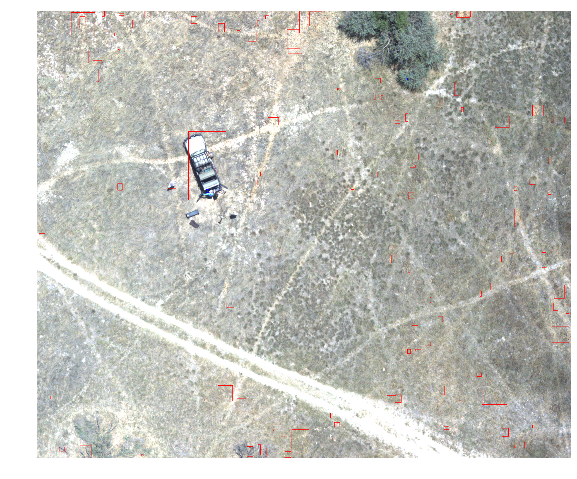

In [274]:
regions = AssignRegions(mask)
ScoreRegions(regions, qimage, hist)
PruneRegions(regions)

pruned_image = np.copy(image)
MarkRegions(pruned_image, regions)

my_dpi = 160
plt.figure(figsize=(1900/my_dpi, 1280/my_dpi), dpi=my_dpi)
plt.axis('off')
plt.imshow(pruned_image)

In [280]:
len(regions.catalog)

138

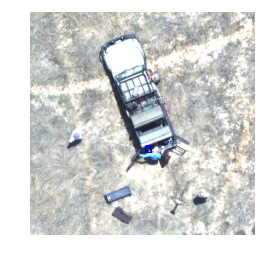

In [275]:
thumb = image[512:1024,512:1024]
gray = cv2.cvtColor(thumb, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.axis('off')
plt.imshow(thumb)

min_r=0, max_r=255, bin_spacing.r=32
min_g=0, max_g=255, bin_spacing.g=32
min_b=39, max_b=255, bin_spacing.b=28
image height=512,width=512,depth=3
qimage height=512,width=512,depth=3


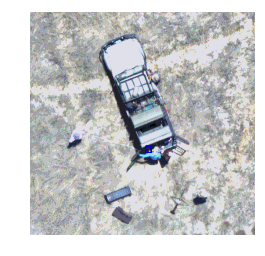

In [276]:
bin = InitBin(thumb)
lut = InitLUT(bin)
thumb_qimage = quantize(thumb, lut)
thumb_dimage = unquantize(thumb_qimage, bin)

plt.axis('off')
plt.imshow(thumb_dimage)

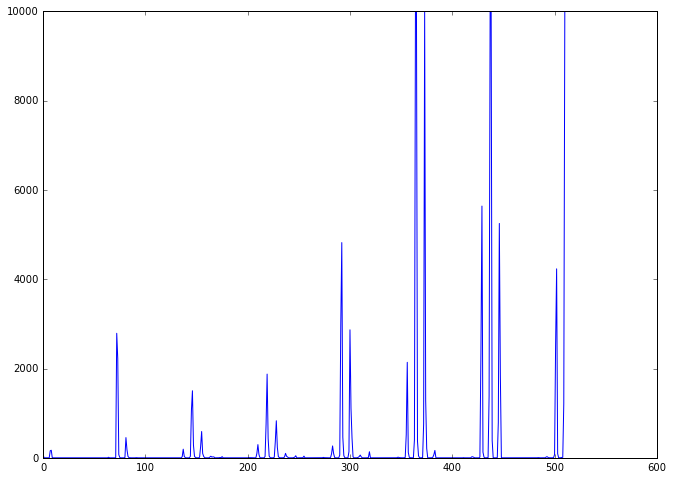

In [277]:
thumb_hist = BuildHistogram(thumb_qimage)
hist_index = range(512)

my_dpi = 160
plt.figure(figsize=(1900/my_dpi, 1280/my_dpi), dpi=my_dpi)
plt.plot(hist_index, thumb_hist)

qimage height=512,width=512,depth=3


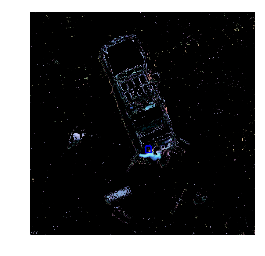

In [278]:
thumb_mask = HistogramThreshold(thumb_qimage, thumb_hist)
thumb_dimage = unquantize(thumb_mask, bin)

plt.axis('off')
plt.imshow(thumb_dimage)

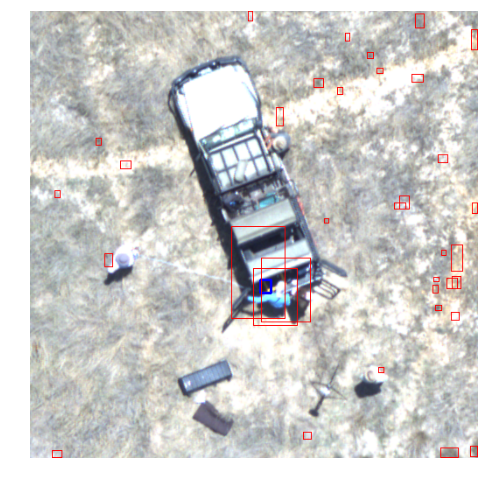

In [279]:
thumb_regions = AssignRegions(thumb_mask)
ScoreRegions(thumb_regions, thumb_qimage, thumb_hist)
PruneRegions(thumb_regions)

pruned_thumb = np.copy(thumb)
MarkRegions(pruned_thumb, thumb_regions)

my_dpi = 160
plt.figure(figsize=(1900/my_dpi, 1280/my_dpi), dpi=my_dpi)
plt.axis('off')
plt.imshow(pruned_thumb)

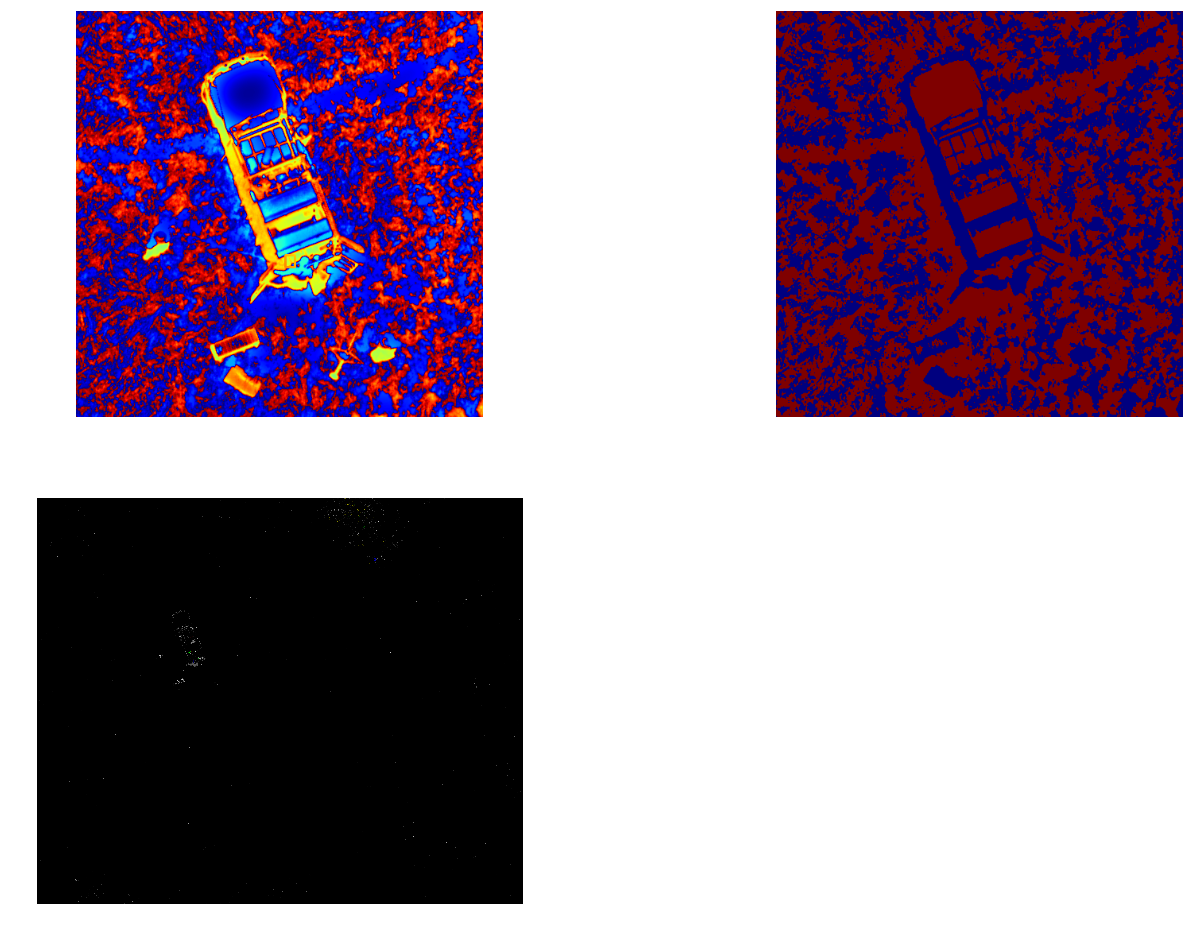

In [281]:
gray = cv2.cvtColor(thumb, cv2.COLOR_BGR2GRAY)

my_dpi = 80
plt.figure(figsize=(1900/my_dpi, 1280/my_dpi), dpi=my_dpi)

# subplot(m,n,p), where:
# m = number of rows
# n = number of columns
# p = grid to place the image, with index 1
plt.subplot(221)
lowpass = ndimage.gaussian_filter(gray, 16)
gauss_highpass = gray - lowpass
plt.axis('off')
plt.imshow(gauss_highpass)

plt.subplot(222)
filter = gauss_highpass < gauss_highpass.mean()
plt.axis('off')
plt.imshow(filter)

plt.subplot(223)
label_im, nb_labels = ndimage.label(mask)
plt.axis('off')
plt.imshow(label_im)

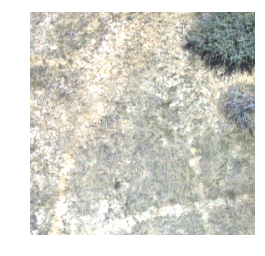

In [282]:
thumb = image[0:512,1024:1536]
plt.axis('off')
plt.imshow(thumb)

In [ ]:
plot(hist(thumb))

In [ ]:
thumb = image[1024:1536,0:512]
plt.axis('off')
plt.imshow(thumb)

In [ ]:
plot(hist(thumb))

In [ ]:
1 << 3